In [63]:
%config Completer.use_jedi = False

**Корректность проверена на Python 3.7:**
+ pandas 0.23.0
+ numpy 1.14.5
+ sklearn 0.19.1

# Доверительные интервалы для оценки среднего

In [64]:
import numpy as np
import scipy.stats as stats
from sklearn import datasets, linear_model, metrics, model_selection

In [65]:
import sklearn

print(np.__version__)
print(sklearn.__version__)

1.20.3
0.24.2


In [66]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Генерация данных

In [67]:
blobs = datasets.make_blobs(300, centers=2, cluster_std=6, random_state=1)

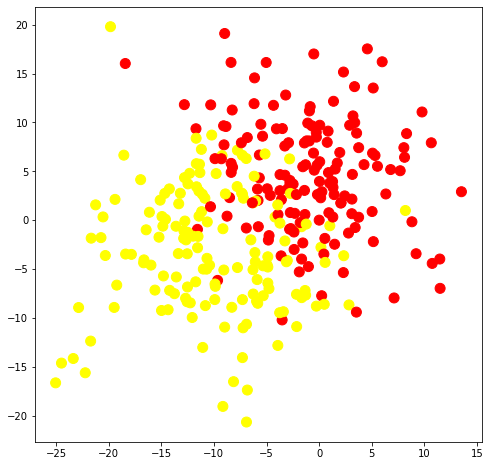

In [68]:
pylab.figure(figsize(8, 8))
pylab.scatter(
    list(map(lambda x: x[0], blobs[0])),
    list(map(lambda x: x[1], blobs[0])),
    c=blobs[1],
    cmap="autumn",
    s=100,
)

## Сравнение линейных моделей

### Точечная оценка

In [69]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    blobs[0], blobs[1], test_size=15, random_state=1
)

In [70]:
ridge_model = linear_model.RidgeClassifier()
ridge_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, ridge_model.predict(test_data))

0.8888888888888888

In [71]:
sgd_model = linear_model.SGDClassifier(random_state=0, max_iter=1000)
sgd_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, sgd_model.predict(test_data))

0.7777777777777778

### Оценка среднего

In [72]:
sgd_auc_scores = model_selection.cross_val_score(
    linear_model.SGDClassifier(max_iter=1000),
    blobs[0],
    blobs[1],
    scoring="roc_auc",
    cv=20,
)

In [73]:
ridge_auc_scores = model_selection.cross_val_score(
    linear_model.RidgeClassifier(), blobs[0], blobs[1], scoring="roc_auc", cv=20
)

### Точечная оценка среднего

In [74]:
print(
    "sgd model auc: mean %.3f, std %.3f"
    % (sgd_auc_scores.mean(), sgd_auc_scores.std(ddof=1))
)
print(
    "ridge model auc: mean %.3f, std %.3f"
    % (ridge_auc_scores.mean(), ridge_auc_scores.std(ddof=1))
)

sgd model auc: mean 0.883, std 0.184
ridge model auc: mean 0.937, std 0.071


### Интервальная оценка среднего 

In [75]:
from statsmodels.stats.weightstats import _tconfint_generic, _zconfint_generic

In [76]:
sgd_mean = sgd_auc_scores.mean()
ridge_mean = ridge_auc_scores.mean()

#### z-интервал

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [77]:
print(
    "sgd model mean auc 95%% confidence interval",
    _zconfint_generic(sgd_mean, sqrt(0.25 / len(sgd_auc_scores)), 0.05, "two-sided"),
)

print(
    "ridge model mean auc 95%% confidence interval",
    _zconfint_generic(ridge_mean, sqrt(0.25 / len(sgd_auc_scores)), 0.05, "two-sided"),
)

sgd model mean auc 95%% confidence interval (0.6639050791415688, 1.1021663494298597)
ridge model mean auc 95%% confidence interval (0.7174765077129974, 1.155737778001288)


#### t-интервал

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [78]:
type(sgd_auc_scores)

numpy.ndarray

In [79]:
sgd_mean_std = sgd_auc_scores.std(ddof=1) / sqrt(len(sgd_auc_scores))
ridge_mean_std = ridge_auc_scores.std(ddof=1) / sqrt(len(ridge_auc_scores))

In [80]:
print(
    "sgd model mean auc 95%% confidence interval",
    _tconfint_generic(
        sgd_mean, sgd_mean_std, len(sgd_auc_scores) - 1, 0.05, "two-sided"
    ),
)

print(
    "ridge model mean auc 95%% confidence interval",
    _tconfint_generic(
        ridge_mean, ridge_mean_std, len(sgd_auc_scores) - 1, 0.05, "two-sided"
    ),
)

sgd model mean auc 95%% confidence interval (0.7969707225962266, 0.9691007059752019)
ridge model mean auc 95%% confidence interval (0.903235324375978, 0.9699789613383075)


In [81]:
alpha = 0.003
snd = stats.norm()
z = snd.ppf(1 - 0.003 / 2)

In [83]:
104 / 11037 - (189 / 11034)

-0.0077060239760047815

In [84]:
np.round(stats.norm.ppf(0.003 / 2), 4)

-2.9677

In [153]:
def get_bootstrap_samples(data, n_samples):
    random.seed(0)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [154]:
asp_samples, no_asp_samples = get_bootstrap_samples(asp, 1000), get_bootstrap_samples(
    no_asp, 1000
)
asp_means, no_asp_means = list(map(np.mean, asp_samples)), list(
    map(np.mean, no_asp_samples)
)
delta_means = list(map(lambda x: x[0] - x[1], zip(asp_means, no_asp_means)))

In [155]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries

In [156]:
stat_intervals(delta_means, 0.05)

array([-0.00924693, -0.00607481])

In [92]:
from statsmodels.stats.proportion import proportion_confint

In [96]:
help(proportion_confint)

Help on function proportion_confint in module statsmodels.stats.proportion:

proportion_confint(count, nobs, alpha=0.05, method='normal')
    confidence interval for a binomial proportion
    
    Parameters
    ----------
    count : int or array_array_like
        number of successes, can be pandas Series or DataFrame
    nobs : int
        total number of trials
    alpha : float in (0, 1)
        significance level, default 0.05
    method : {'normal', 'agresti_coull', 'beta', 'wilson', 'binom_test'}
        default: 'normal'
        method to use for confidence interval,
        currently available methods :
    
         - `normal` : asymptotic normal approximation
         - `agresti_coull` : Agresti-Coull interval
         - `beta` : Clopper-Pearson interval based on Beta distribution
         - `wilson` : Wilson Score interval
         - `jeffreys` : Jeffreys Bayesian Interval
         - `binom_test` : experimental, inversion of binom_test
    
    Returns
    -------
    ci_l

In [150]:
def calculate():
    p_asp, p_no_asp = 104 / 11037, 189 / 11034
    asp_ci, no_asp_ci = proportion_confint(
        104, len(asp), 0.05, "wilson"
    ), proportion_confint(189, len(no_asp), 0.05, "wilson")
    alpha = 0.05
    z = snd.ppf(1 - alpha / 2)
    proportion_ci_left = (
        p_no_asp
        - p_asp
        - z
        * math.sqrt(
            (p_asp * (1 - p_asp) / len(asp)) + (p_no_asp * (1 - p_no_asp) / len(no_asp))
        )
    )
    proportion_ci_right = (
        p_no_asp
        - p_asp
        + z
        * math.sqrt(
            (p_asp * (1 - p_asp) / len(asp)) + (p_no_asp * (1 - p_no_asp) / len(no_asp))
        )
    )
    return round(proportion_ci_left, 4), round(proportion_ci_right, 4)

In [151]:
calculate()

(0.0047, 0.0107)

In [173]:
# @logger.catch
def func():
    def calculate_odds(success_count, full_count):
        return float(success_count) / float(full_count - success_count)

    aspirin_n = 11037
    placebo_n = 11034
    aspirin_infarct_n = 104
    placebo_infarct_n = 189
    aspirin_odds = calculate_odds(aspirin_infarct_n, aspirin_n)
    placebo_odds = calculate_odds(placebo_infarct_n, placebo_n)
    aspirin_vector = np.append(
        np.ones(int(aspirin_infarct_n), dtype=int),
        np.zeros(int(aspirin_n - aspirin_infarct_n), dtype=int),
    )
    placebo_vector = np.append(
        np.ones(int(placebo_infarct_n), dtype=int),
        np.zeros(int(placebo_n - placebo_infarct_n), dtype=int),
    )
    # %%

    def get_bootstrap_samples(data, n_samples):
        data_length = len(data)
        indices = np.random.randint(0, data_length, (n_samples, data_length))
        return data[indices]

    # %%
    np.random.seed(0)
    aspirin_samples = get_bootstrap_samples(aspirin_vector, 1000)
    placebo_samples = get_bootstrap_samples(placebo_vector, 1000)
    # %%

    def calculate_odds_from_samples(samples):
        samples_count = len(samples)
        success_count = len(samples[samples == 1])
        return calculate_odds(success_count, samples_count)

    # %%
    all_aspirin_odds = list(map(calculate_odds_from_samples, aspirin_samples))
    all_placebo_odds = list(map(calculate_odds_from_samples, placebo_samples))

    # %%
    def stat_intervals(stat, alpha):
        boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
        return boundaries

    # %%
    odds = list(map(lambda x, y: x / y, zip(all_aspirin_odds, all_placebo_odds)))
    # %%
    print(np.round(stat_intervals(odds, 0.05), 4))